In [ ]:
# Disable wandb and import libs
import os
os.environ["WANDB_DISABLED"] = "true"  # prevents wandb login prompt
# (set before importing Trainer & HF libs)

import sys
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split

from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
    DataCollatorWithPadding, Trainer, TrainingArguments, set_seed
)

print("torch:", torch.__version__, " CUDA available:", torch.cuda.is_available())
import transformers
print("transformers:", transformers.__version__)
set_seed(42)

torch: 2.6.0+cu124  CUDA available: True
transformers: 4.55.1


In [ ]:
# Cell 3 - Load excel (works in Colab or local)
DATA_PATH = "economics_test_items_3000_unique_v8.xlsx"   # change if your filename differs

if not os.path.exists(DATA_PATH):
    # try Colab file picker
    try:
        from google.colab import files
        print(f"'{DATA_PATH}' not found. Please upload the file now (file picker will appear).")
        uploaded = files.upload()
        # take the first uploaded filename
        DATA_PATH = list(uploaded.keys())[0]
    except Exception:
        raise FileNotFoundError(f"File '{DATA_PATH}' not found in working dir. Place it next to the notebook or upload.")

print("Loading:", DATA_PATH)
df = pd.read_excel(DATA_PATH, engine="openpyxl")
print("Dataset rows:", len(df))
print("Columns:", df.columns.tolist())
display(df.head())


Loading: economics_test_items_3000_unique_v8.xlsx
Dataset rows: 3000
Columns: ['No', 'Question ID', 'Bloom_Level', 'Topic', 'Question_Text', 'Option A', 'Option B', 'Option C', 'Option D', 'Correct Option']


,No,Question ID,Bloom_Level,Topic,Question_Text,Option A,Option B,Option C,Option D,Correct Option
0,1,Q0001,Analyze,Public Finance,Explain how a prolonged drought affecting harv...,It lowers unemployment,Improved export competitiveness,It increases government revenue,It improves competitiveness,B
1,2,Q0002,Understand,International,If Zambia's central bank reduces the policy ra...,It worsens the trade balance,Increase in short-run aggregate demand,It raises interest rates,It reduces supply,B
2,3,Q0003,Create,Money & Banking,Draft a policy mix consisting of three measure...,Only export promotion schemes,cash transfers; technology grants; industrial ...,credit guarantee schemes; skills training and ...,export credit insurance; industrial parks; imp...,D
3,4,Q0004,Evaluate,Micro,Which combination of policies best reduces inf...,Public investment in infrastructure with targe...,It improves productivity,It increases government revenue,It is inflationary,A
4,5,Q0005,Understand,Public Finance,If South Africa's central bank reduces the pol...,It raises interest rates,It reduces aggregate demand,It lowers unemployment,Increase in short-run aggregate demand,D


In [ ]:
df["Bloom_Level"].unique()

array(['Analyze', 'Understand', 'Create', 'Evaluate', 'Apply', 'Remember'],
      dtype=object)

In [ ]:
# Cell 4 - Auto-detect columns (override TEXT_COL / LABEL_COL if needed)
candidates_text = [c for c in df.columns if any(k in c.lower() for k in ["Question_Text", "quest", "stem", "item", "text"])]
candidates_label = [c for c in df.columns if any(k in c.lower() for k in ["Bloom_Level", "level", "taxonomy", "label", "class"])]

TEXT_COL = candidates_text[1] if candidates_text else df.columns[0]
LABEL_COL = candidates_label[0] if candidates_label else df.columns[1] if len(df.columns)>1 else df.columns[0]

print("Using TEXT column:", TEXT_COL)
print("Using LABEL column:", LABEL_COL)
print("Example texts:")
display(df[[TEXT_COL, LABEL_COL]].head())
# If these are wrong, set TEXT_COL and LABEL_COL manually here and re-run this cell.


Using TEXT column: Question_Text
Using LABEL column: Bloom_Level
Example texts:


,Question_Text,Bloom_Level
0,Explain how a prolonged drought affecting harv...,Analyze
1,If Zambia's central bank reduces the policy ra...,Understand
2,Draft a policy mix consisting of three measure...,Create
3,Which combination of policies best reduces inf...,Evaluate
4,If South Africa's central bank reduces the pol...,Understand


In [ ]:
# Cell 5 - Normalize label text and map synonyms to canonical Bloom names
# Cell 5 - Normalize label text and map synonyms to canonical Bloom names
def normalize_label(s):
    if pd.isna(s):
        return None
    key = str(s).strip().lower()

    # canonical Bloom categories
    canon = ["Remember", "Understand", "Apply", "Analyze", "Evaluate", "Create"]

    # mapping of common variants
    synonyms = {
        "remember": "Remember", "recall": "Remember",
        "understand": "Understand", "comprehend": "Understand",
        "apply": "Apply", "application": "Apply", "use": "Apply",
        "analyse": "Analyze", "analyze": "Analyze", "analysis": "Analyze",
        "evaluate": "Evaluate", "evaluation": "Evaluate", "assessment": "Evaluate",
        "create": "Create", "synthesis": "Create"
    }

    # if multiple levels are joined with '/', take the FIRST one only
    if "/" in key:
        first = key.split("/")[0].strip()
        if first in synonyms:
            return synonyms[first]
        elif first.title() in canon:
            return first.title()

    # direct match in synonyms
    if key in synonyms:
        return synonyms[key]

    # exact canonical match
    if key.title() in canon:
        return key.title()

    # fallback: try partial matching to map close variants
    for k, v in synonyms.items():
        if k in key:
            return v

    # last fallback: return None (forces drop)
    return None

# create normalized label column
df["bloom_norm"] = df[LABEL_COL].apply(normalize_label)

print("Unique normalized labels:", df["bloom_norm"].unique())

# Warn if unexpected labels remain
unexpected = [x for x in df["bloom_norm"].unique() if x not in ["Remember","Understand","Apply","Analyze","Evaluate","Create",None]]
if unexpected:
    print("WARNING - unexpected label values detected:", unexpected)

# Drop rows with unmapped labels
df = df.dropna(subset=["bloom_norm"]).reset_index(drop=True)


# # create normalized label column
# df["bloom_norm"] = df[LABEL_COL].apply(normalize_label)
# print("Unique normalized labels:", df["bloom_norm"].unique())
# # warn about anything unexpected
# unexpected = [x for x in df["bloom_norm"].unique() if x not in ["Remember","Understand","Apply","Analyze","Evaluate", "Create","None"]]
# if unexpected:
#     print("WARNING - unexpected label values detected:", unexpected)
# display(df[[TEXT_COL, LABEL_COL, "bloom_norm"]].head(8))


Unique normalized labels: ['Analyze' 'Understand' 'Create' 'Evaluate' 'Apply' 'Remember']


In [ ]:
# Cell 6 - Define canonical Bloom order (lowest -> highest) and map to integers
bloom_order = ["Remember", "Understand", "Apply", "Analyze", "Evaluate", "Create"]
label2id = {lab: i for i, lab in enumerate(bloom_order)}
id2label = {i: lab for lab, i in label2id.items()}

# map to numeric 'label' column, drop rows that could not be mapped
df["label"] = df["bloom_norm"].map(label2id)
missing_map = df["label"].isna().sum()
if missing_map > 0:
    print(f"WARNING: {missing_map} rows could not be mapped to Bloom levels — they will be dropped. Check 'bloom_norm' for unusual values.")
    display(df[df["label"].isna()][[LABEL_COL, "bloom_norm"]].head(10))

df = df.dropna(subset=["label"]).reset_index(drop=True)
df["label"] = df["label"].astype(int)

print("Final label mapping (low->high):", label2id)
print("Counts per mapped label:")
print(df["label"].value_counts().sort_index())


Final label mapping (low->high): {'Remember': 0, 'Understand': 1, 'Apply': 2, 'Analyze': 3, 'Evaluate': 4, 'Create': 5}
Counts per mapped label:
label
0    500
1    500
2    500
3    500
4    500
5    500
Name: count, dtype: int64


In [ ]:
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# def tokenize(batch):
#     return tokenizer(batch[TEXT_COL], truncation=True, padding="max_length", max_length=256)

# train_ds = train_ds.map(tokenize, batched=True)
# test_ds = test_ds.map(tokenize, batched=True)

# Cell 7 - Deduplicate & stratified split into train/val/test (80/10/10)

# Drop exact text duplicates first to prevent leakage
df = df.drop_duplicates(subset=[TEXT_COL, "label"]).reset_index(drop=True)
print("After removing duplicates:", len(df))

# Stratified split
train_val_df, test_df = train_test_split(
    df,
    test_size=0.10,
    stratify=df["label"],
    random_state=42
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.111111,  # ~10% of original
    stratify=train_val_df["label"],
    random_state=42
)

print("Sizes -> train:", len(train_df), "val:", len(val_df), "test:", len(test_df))

# Confirm no text overlap
overlap_train_val = set(train_df[TEXT_COL]).intersection(set(val_df[TEXT_COL]))
overlap_train_test = set(train_df[TEXT_COL]).intersection(set(test_df[TEXT_COL]))
overlap_val_test = set(val_df[TEXT_COL]).intersection(set(test_df[TEXT_COL]))

print("Overlap train/val:", len(overlap_train_val))
print("Overlap train/test:", len(overlap_train_test))
print("Overlap val/test:", len(overlap_val_test))



After removing duplicates: 3000
Sizes -> train: 2400 val: 300 test: 300
Overlap train/val: 0
Overlap train/test: 0
Overlap val/test: 0


In [ ]:
# # Cell 8 - Convert and rename text col -> "text"
# train_ds = Dataset.from_pandas(train_df[[TEXT_COL, "label"]].rename(columns={TEXT_COL: "text"})).shuffle(seed=42)
# val_ds   = Dataset.from_pandas(val_df[[TEXT_COL, "label"]].rename(columns={TEXT_COL: "text"})).shuffle(seed=42)
# test_ds  = Dataset.from_pandas(test_df[[TEXT_COL, "label"]].rename(columns={TEXT_COL: "text"})).shuffle(seed=42)
# dataset_dict = DatasetDict({"train": train_ds, "validation": val_ds, "test": test_ds})
# print(dataset_dict)

# Cell 8 - Convert and rename text col -> "text"
train_ds = Dataset.from_pandas(train_df[[TEXT_COL, "label"]].rename(columns={TEXT_COL: "text"})).shuffle(seed=42)
val_ds   = Dataset.from_pandas(val_df[[TEXT_COL, "label"]].rename(columns={TEXT_COL: "text"})).shuffle(seed=42)
test_ds  = Dataset.from_pandas(test_df[[TEXT_COL, "label"]].rename(columns={TEXT_COL: "text"})).shuffle(seed=42)

dataset_dict = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds
})
print(dataset_dict)



DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 2400
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 300
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 300
    })
})


In [ ]:
# # Cell 9 - Tokenizer and tokenization
# MODEL_NAME = "distilbert-base-uncased"   # change if you prefer another model
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

# max_length = 128
# def tokenize_batch(batch):
#     return tokenizer(batch["text"], truncation=True, padding=False, max_length=max_length)

# tokenized = dataset_dict.map(tokenize_batch, batched=True, remove_columns=["text"])
# tokenized = tokenized.rename_column("label", "labels")
# tokenized.set_format("torch")
# tokenized

# Cell 9 - Tokenizer and tokenization
MODEL_NAME = "prajjwal1/bert-tiny"  #"distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

max_length = 128
def tokenize_batch(batch):
    return tokenizer(batch["text"], truncation=True, padding=False, max_length=max_length)

tokenized = dataset_dict.map(tokenize_batch, batched=True, remove_columns=["text"])
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format("torch")
tokenized


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2400
    })
    validation: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 300
    })
    test: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 300
    })
})

In [ ]:
# # Cell 10 - Data collator and model (classifier head will be freshly initialized — normal)
# from transformers import AutoConfig, AutoModelForSequenceClassification, DataCollatorWithPadding

# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# num_labels = len(bloom_order)

# config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=num_labels, id2label=id2label, label2id=label2id)
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)
# print("Model loaded. num_labels =", num_labels)


# Cell 10 - Data collator and model
from transformers import AutoConfig, AutoModelForSequenceClassification, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
num_labels = len(bloom_order)

config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)
print("Model loaded. num_labels =", num_labels)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded. num_labels = 6


In [ ]:
# Cell 11 - Optionally mount Google Drive and set output_dir
SAVE_TO_DRIVE = True   # set False if you don't want to save to Drive

if SAVE_TO_DRIVE:
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        output_dir = "/content/drive/MyDrive/hf_bloom_model"
        os.makedirs(output_dir, exist_ok=True)
        print("Model will be saved to Drive:", output_dir)
    except Exception as e:
        print("Could not mount Drive (not in Colab?). Falling back to local folder './hf_bloom_model'")
        output_dir = "./hf_bloom_model"
        os.makedirs(output_dir, exist_ok=True)
else:
    output_dir = "./hf_bloom_model"
    os.makedirs(output_dir, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model will be saved to Drive: /content/drive/MyDrive/hf_bloom_model


In [ ]:
# Cell 12 - Training arguments
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=output_dir,
    # Change "evaluation_strategy" to "eval_strategy"
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    push_to_hub=False,
    fp16=torch.cuda.is_available()
)

print("Training args ready. Output dir:", output_dir)

# Early stopping callback
from transformers import EarlyStoppingCallback
early_stop_callback = EarlyStoppingCallback(early_stopping_patience=2)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training args ready. Output dir: /content/drive/MyDrive/hf_bloom_model


In [ ]:
# Cell 13 - Metrics function
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="macro", zero_division=0)
    recall = recall_score(labels, preds, average="macro", zero_division=0)
    f1 = f1_score(labels, preds, average="macro", zero_division=0)
    return {
        "accuracy": acc,
        "precision_macro": precision,
        "recall_macro": recall,
        "f1_macro": f1
    }


# Cell 14 - Trainer setup
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stop_callback]
)

print("Trainer created.")

trainer.train()




/tmp/ipython-input-1422567166.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Trainer created.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,1.403400,1.311641,0.890000,0.907221,0.890000,0.888853
2,1.213500,1.146260,0.970000,0.970709,0.970000,0.969775


TrainOutput(global_step=600, training_loss=1.4346431477864583, metrics={'train_runtime': 9.8693, 'train_samples_per_second': 486.359, 'train_steps_per_second': 60.795, 'total_flos': 453831630624.0, 'train_loss': 1.4346431477864583, 'epoch': 2.0})

In [ ]:
# # Cell 14 - Train (this may take time depending on dataset & GPU)
# train_result = trainer.train()
# trainer.save_model(output_dir)
# print("Training finished, model saved to:", output_dir)
# train_result


In [ ]:
# # Cell 15 - Evaluate
print("Validation metrics:")
print(trainer.evaluate(tokenized["validation"]))

print("\nTest metrics:")
print(trainer.evaluate(tokenized["test"]))

# Cell 15 - Final evaluation on test set
test_results = trainer.evaluate(tokenized["test"])
print("\nTest results:", test_results)



Validation metrics:


{'eval_loss': 1.1462597846984863, 'eval_accuracy': 0.97, 'eval_precision_macro': 0.9707088989441931, 'eval_recall_macro': 0.9700000000000001, 'eval_f1_macro': 0.9697746307138453, 'eval_runtime': 0.1112, 'eval_samples_per_second': 2697.151, 'eval_steps_per_second': 89.905, 'epoch': 2.0}

Test metrics:
{'eval_loss': 1.1548681259155273, 'eval_accuracy': 0.9766666666666667, 'eval_precision_macro': 0.9783125371360666, 'eval_recall_macro': 0.9766666666666666, 'eval_f1_macro': 0.9762183591631052, 'eval_runtime': 0.1125, 'eval_samples_per_second': 2666.69, 'eval_steps_per_second': 88.89, 'epoch': 2.0}

Test results: {'eval_loss': 1.1548681259155273, 'eval_accuracy': 0.9766666666666667, 'eval_precision_macro': 0.9783125371360666, 'eval_recall_macro': 0.9766666666666666, 'eval_f1_macro': 0.9762183591631052, 'eval_runtime': 0.1167, 'eval_samples_per_second': 2570.433, 'eval_steps_per_second': 85.681, 'epoch': 2.0}


In [ ]:
# Cell X - Predict on test set
predictions = trainer.predict(tokenized["test"])

# Extract logits and predicted labels
logits = predictions.predictions
probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
pred_labels = np.argmax(probs, axis=-1)

# Map back to Bloom labels
pred_bloom = [id2label[int(i)] for i in pred_labels]
true_bloom = [id2label[int(i)] for i in tokenized["test"]["labels"]]

# Show a few examples
for i in range(10):
    print(f"Text: {dataset_dict['test'][i]['text']}")
    print(f"True: {true_bloom[i]} | Pred: {pred_bloom[i]}")
    print("-" * 80)



Text: If nominal GDP rises from 1552 to 2218 while the price level is constant, the real GDP change is: 
True: Apply | Pred: Apply
--------------------------------------------------------------------------------
Text: Explain how an unexpected devaluation of the currency would influence the mining sector over the next year. Which outcome follows?
True: Analyze | Pred: Analyze
--------------------------------------------------------------------------------
Text: Which option most closely matches the definition of total factor productivity according to classical theory
True: Remember | Pred: Remember
--------------------------------------------------------------------------------
Text: Devise a practical 3-point strategy in the mining sector. Context: Implement within 1 years. Which set of measures is most balanced?
True: Create | Pred: Create
--------------------------------------------------------------------------------
Text: In the event of a technology shock boosting productivity in

In [ ]:
import pandas as pd

# Cell X - Predict on test set
predictions = trainer.predict(tokenized["test"])

# Extract logits and predicted labels
logits = predictions.predictions
probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
pred_labels = np.argmax(probs, axis=-1)

# Map back to Bloom labels
pred_bloom = [id2label[int(i)] for i in pred_labels]
true_bloom = [id2label[int(i)] for i in tokenized["test"]["labels"]]
texts = dataset_dict["test"]["text"]

# Build DataFrame
results_df = pd.DataFrame({
    "Text": texts,
    "True_Label": true_bloom,
    "Predicted_Label": pred_bloom,
    "Confidence": probs.max(axis=1)
})

# Show first rows
display(results_df.head(10))


,Text,True_Label,Predicted_Label,Confidence
0,If nominal GDP rises from 1552 to 2218 while t...,Apply,Apply,0.332636
1,Explain how an unexpected devaluation of the c...,Analyze,Analyze,0.262066
2,Which option most closely matches the definiti...,Remember,Remember,0.247145
3,Devise a practical 3-point strategy in the min...,Create,Create,0.421585
4,In the event of a technology shock boosting pr...,Analyze,Analyze,0.271003
5,Draft a policy mix consisting of three measure...,Create,Create,0.418832
6,If nominal GDP rises from 6837 to 8379 while t...,Apply,Apply,0.339269
7,Devise a practical 3-point strategy for Senega...,Create,Create,0.419701
8,"In economics, reserve requirement refers to:",Remember,Remember,0.261526
9,What is the primary meaning of for a developin...,Remember,Remember,0.242729


In [ ]:
results_df.to_excel("bloom_predictions.xlsx", index=False)


In [ ]:
results_df

,Text,True_Label,Predicted_Label,Confidence
0,If nominal GDP rises from 1552 to 2218 while t...,Apply,Apply,0.332636
1,Explain how an unexpected devaluation of the c...,Analyze,Analyze,0.262066
2,Which option most closely matches the definiti...,Remember,Remember,0.247145
3,Devise a practical 3-point strategy in the min...,Create,Create,0.421585
4,In the event of a technology shock boosting pr...,Analyze,Analyze,0.271003
...,...,...,...,...
295,Given a large government infrastructure progra...,Analyze,Analyze,0.289025
296,What do economists mean by public good? accord...,Remember,Remember,0.288723
297,Explain how a technology shock boosting produc...,Analyze,Analyze,0.275228
298,Determine how a prolonged drought affecting ha...,Analyze,Analyze,0.273636


In [ ]:
# Define mapping
difficulty_map = {
    "Remember": "Easy",
    "Understand": "Easy",
    "Apply": "Medium",
    "Analyze": "Medium",
    "Evaluate": "Difficult",
    "Create": "Difficult"
}

# Apply mapping to your DataFrame with Bloom predictions
results_df["True_Difficulty"] = results_df["True_Label"].map(difficulty_map)
results_df["Predicted_Difficulty"] = results_df["Predicted_Label"].map(difficulty_map)

display(results_df.head(10))


,Text,True_Label,Predicted_Label,Confidence,True_Difficulty,Predicted_Difficulty
0,If nominal GDP rises from 1552 to 2218 while t...,Apply,Apply,0.332636,Medium,Medium
1,Explain how an unexpected devaluation of the c...,Analyze,Analyze,0.262066,Medium,Medium
2,Which option most closely matches the definiti...,Remember,Remember,0.247145,Easy,Easy
3,Devise a practical 3-point strategy in the min...,Create,Create,0.421585,Difficult,Difficult
4,In the event of a technology shock boosting pr...,Analyze,Analyze,0.271003,Medium,Medium
5,Draft a policy mix consisting of three measure...,Create,Create,0.418832,Difficult,Difficult
6,If nominal GDP rises from 6837 to 8379 while t...,Apply,Apply,0.339269,Medium,Medium
7,Devise a practical 3-point strategy for Senega...,Create,Create,0.419701,Difficult,Difficult
8,"In economics, reserve requirement refers to:",Remember,Remember,0.261526,Easy,Easy
9,What is the primary meaning of for a developin...,Remember,Remember,0.242729,Easy,Easy


In [ ]:
# Count distribution by Bloom level
bloom_dist = results_df["True_Label"].value_counts().sort_index()
print("Distribution by Bloom’s Taxonomy level:\n")
print(bloom_dist)

# Count distribution by Difficulty level
diff_dist = results_df["True_Difficulty"].value_counts()
print("\nDistribution by Difficulty level:\n")
print(diff_dist)

# Cross-tab: True vs Predicted Bloom
bloom_crosstab = pd.crosstab(results_df["True_Label"], results_df["Predicted_Label"], normalize="index")
print("\nBloom’s Level: True vs Predicted (row-normalized):\n")
print(bloom_crosstab.round(2))

# Cross-tab: True vs Predicted Difficulty
diff_crosstab = pd.crosstab(results_df["True_Difficulty"], results_df["Predicted_Difficulty"], normalize="index")
print("\nDifficulty Level: True vs Predicted (row-normalized):\n")
print(diff_crosstab.round(2))


Distribution by Bloom’s Taxonomy level:

True_Label
Analyze       50
Apply         50
Create        50
Evaluate      50
Remember      50
Understand    50
Name: count, dtype: int64

Distribution by Difficulty level:

True_Difficulty
Medium       100
Easy         100
Difficult    100
Name: count, dtype: int64

Bloom’s Level: True vs Predicted (row-normalized):

Predicted_Label  Analyze  Apply  Create  Evaluate  Remember  Understand
True_Label                                                             
Analyze             1.00    0.0     0.0      0.00       0.0        0.00
Apply               0.00    1.0     0.0      0.00       0.0        0.00
Create              0.00    0.0     1.0      0.00       0.0        0.00
Evaluate            0.00    0.0     0.0      1.00       0.0        0.00
Remember            0.00    0.0     0.0      0.00       1.0        0.00
Understand          0.02    0.0     0.0      0.02       0.1        0.86

Difficulty Level: True vs Predicted (row-normalized):

Predic

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# True vs predicted Bloom
y_true_bloom = results_df["True_Label"]
y_pred_bloom = results_df["Predicted_Label"]

# Overall metrics
acc = accuracy_score(y_true_bloom, y_pred_bloom)
precision = precision_score(y_true_bloom, y_pred_bloom, average="macro", zero_division=0)
recall = recall_score(y_true_bloom, y_pred_bloom, average="macro", zero_division=0)
f1 = f1_score(y_true_bloom, y_pred_bloom, average="macro", zero_division=0)

print("Overall Bloom-Level Metrics")
print("---------------------------")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}\n")

# Detailed per-class report
print("Per-Class Bloom-Level Report")
print("----------------------------")
print(classification_report(y_true_bloom, y_pred_bloom, zero_division=0))


Overall Bloom-Level Metrics
---------------------------
Accuracy : 0.977
Precision: 0.978
Recall   : 0.977
F1 Score : 0.976

Per-Class Bloom-Level Report
----------------------------
              precision    recall  f1-score   support

     Analyze       0.98      1.00      0.99        50
       Apply       1.00      1.00      1.00        50
      Create       1.00      1.00      1.00        50
    Evaluate       0.98      1.00      0.99        50
    Remember       0.91      1.00      0.95        50
  Understand       1.00      0.86      0.92        50

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [ ]:
# Build metrics per Bloom level
metrics_data = []
for bloom_class in sorted(results_df["True_Label"].unique(), key=lambda x: label2id[x]):
    y_true_bin = (y_true_bloom == bloom_class).astype(int)
    y_pred_bin = (y_pred_bloom == bloom_class).astype(int)

    precision = precision_score(y_true_bin, y_pred_bin, zero_division=0)
    recall = recall_score(y_true_bin, y_pred_bin, zero_division=0)
    f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)

    metrics_data.append([bloom_class, precision, recall, f1])

metrics_df = pd.DataFrame(metrics_data, columns=["Bloom Level", "Precision", "Recall", "F1 Score"])

# Add overall row
metrics_df.loc[len(metrics_df)] = ["Overall",
                                   precision_score(y_true_bloom, y_pred_bloom, average="macro", zero_division=0),
                                   recall_score(y_true_bloom, y_pred_bloom, average="macro", zero_division=0),
                                   f1_score(y_true_bloom, y_pred_bloom, average="macro", zero_division=0)]

display(metrics_df)


,Bloom Level,Precision,Recall,F1 Score
0,Remember,0.909091,1.000000,0.952381
1,Understand,1.000000,0.860000,0.924731
2,Apply,1.000000,1.000000,1.000000
3,Analyze,0.980392,1.000000,0.990099
4,Evaluate,0.980392,1.000000,0.990099
5,Create,1.000000,1.000000,1.000000
6,Overall,0.978313,0.976667,0.976218


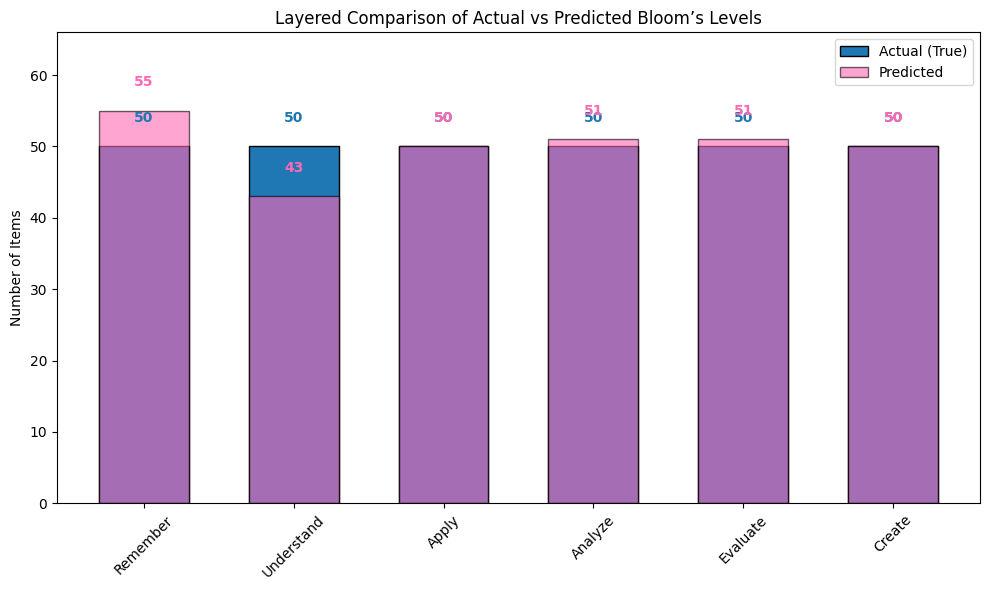

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Super attractive color blend
true_color = "#1f77b4"      # deep blue
pred_color = "#ff69b4"      # hot pink
alpha_pred = 0.6             # transparency for predicted

# Count distributions
true_counts = results_df["True_Label"].value_counts().sort_index(key=lambda x: [label2id[i] for i in x])
pred_counts = results_df["Predicted_Label"].value_counts().sort_index(key=lambda x: [label2id[i] for i in x])

# Align order of labels
labels = list(label2id.keys())
true_vals = [true_counts.get(l, 0) for l in labels]
pred_vals = [pred_counts.get(l, 0) for l in labels]

# Layered bar chart
x = np.arange(len(labels))
width = 0.6

plt.figure(figsize=(10,6))
# Actual bars
bars_actual = plt.bar(x, true_vals, width=width, label="Actual (True)", color=true_color, edgecolor="black")
# Predicted bars layered on top with transparency
bars_pred = plt.bar(x, pred_vals, width=width, label="Predicted", color=pred_color, alpha=alpha_pred, edgecolor="black")

# Annotate counts on each bar
for i in range(len(labels)):
    plt.text(x[i], true_vals[i] + 3, str(true_vals[i]), ha='center', va='bottom', fontweight='bold', color=true_color)
    plt.text(x[i], pred_vals[i] + 3, str(pred_vals[i]), ha='center', va='bottom', fontweight='bold', color=pred_color)

plt.xticks(x, labels, rotation=45)
plt.ylabel("Number of Items")
plt.title("Layered Comparison of Actual vs Predicted Bloom’s Levels")
plt.ylim(0, max(max(true_vals), max(pred_vals)) * 1.2)  # Y-axis starts from 0
plt.legend()
plt.tight_layout()
plt.show()


Test Data

In [ ]:
# Define paths
model_save_path = "./hf_bloom_model_saved"
tokenizer_save_path = "./hf_bloom_tokenizer"

# Save model
model.save_pretrained(model_save_path)
# Save tokenizer
tokenizer.save_pretrained(tokenizer_save_path)

print(f"Model saved to: {model_save_path}")
print(f"Tokenizer saved to: {tokenizer_save_path}")


Model saved to: ./hf_bloom_model_saved
Tokenizer saved to: ./hf_bloom_tokenizer


In [ ]:
# Save as Excel
results_df.to_excel("bloom_predictions.xlsx", index=False)

# Save as CSV
results_df.to_csv("bloom_predictions.csv", index=False)

print("Predictions DataFrame saved as 'bloom_predictions.xlsx' and 'bloom_predictions.csv'")


Predictions DataFrame saved as 'bloom_predictions.xlsx' and 'bloom_predictions.csv'
